<a href="https://colab.research.google.com/github/safwanp314/QuadX/blob/master/munit_cari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# %%capture
# !wget https://github.com/shaoanlu/faceswap-GAN/raw/master/networks/instance_normalization.py
# !wget https://raw.githubusercontent.com/shaoanlu/faceswap-GAN/master/networks/GroupNormalization.py

In [2]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.metrics import mse
import keras.backend as K

Using TensorFlow backend.


In [0]:
from instance_normalization import InstanceNormalization
from GroupNormalization import GroupNormalization

In [0]:
# Architecture configs
IMAGE_SHAPE = (128, 128, 3)

# number of input channels of generators
nc_in = 3

# style latent dim
n_dim_style = 8

# number of residual blocks in decoder and content encoder
n_resblocks = 3

n_dim_adain = 256

# number of channels of the first conv2d of encoder
nc_base = 64
# number of content encoder dowscaling
n_downscale_content = 2

use_groupnorm=False


In [0]:
##################################################################################
# Basic Blocks
##################################################################################
def conv_block(input_tensor, f, k=3, strides=2, use_norm=False):
    x = input_tensor
    x = ReflectPadding2D(x)
    x = Conv2D(f, kernel_size=k, strides=strides, kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4),
               use_bias=(not use_norm), padding='valid')(x)
    if use_norm:
        x = InstanceNormalization(epsilon=1e-5)(x)
    x = Activation('relu')(x)
    return x

def upscale_nn(inp, f, use_norm=False):
    x = inp
    x = UpSampling2D()(x)
    x = ReflectPadding2D(x, 2)
    x = Conv2D(f, kernel_size=5, kernel_initializer='he_normal', 
               kernel_regularizer=l2(1e-4), 
               use_bias=(not use_norm), padding='valid')(x)
    if use_norm:
        if use_groupnorm:
            x = GroupNormalization(group=32)(x)
        else:
            x = GroupNormalization(group=f)(x) # group=f equivalant to layer norm
    x = Activation('relu')(x)
    return x
  
def ReflectPadding2D(x, pad=1):
    x = Lambda(lambda x: tf.pad(x, [[0, 0], [pad, pad], [pad, pad], [0, 0]], mode='REFLECT'))(x)
    return x

In [0]:
def build_style_encoder(nc_in=3, input_size=IMAGE_SHAPE[0], n_dim_style=n_dim_style):
  # number of channels of the first conv2d of encoder
  nc_base = 64
  # number of style encoder dowscaling
  n_dowscale_style = 4

  # Style encoder architecture 
  inp = Input(shape=(input_size, input_size, nc_in))
  x = ReflectPadding2D(inp, 3)
  x = Conv2D(64, kernel_size=7, kernel_initializer='he_normal', 
              kernel_regularizer=l2(1e-4),
              use_bias=True, padding='valid')(x)
  x = Activation('relu')(x)   
  x = Dropout(0.1)(x)

  dim = 1
  for i in range(n_dowscale_style):
      dim = 4 if dim >= 4 else dim*2
      x = conv_block(x, dim * nc_base)
      x = Dropout(0.1)(x)

  x = GlobalAveragePooling2D()(x)    
      
  # Style code
  style_code = Dense(n_dim_style, kernel_regularizer=l2(1e-4))(x)
  
  return Model(inp, style_code)

In [7]:
style_encoder = build_style_encoder()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
def build_content_encoder(nc_in=3, input_size=IMAGE_SHAPE[0], n_resblocks=n_resblocks):
  # Content encoder architecture 
  def res_block_content(input_tensor, f):
      x = input_tensor
      x = ReflectPadding2D(x)
      x = Conv2D(f, kernel_size=3, kernel_initializer='he_normal', 
                  kernel_regularizer=l2(1e-4),
                  use_bias=False, padding='valid')(x)
      x = InstanceNormalization(epsilon=1e-5)(x)
      x = Activation('relu')(x)
      x = ReflectPadding2D(x)
      x = Conv2D(f, kernel_size=3, kernel_initializer='he_normal', 
                  kernel_regularizer=l2(1e-4),
                  use_bias=False, padding='valid')(x)
      x = Dropout(0.1)(x)
      x = InstanceNormalization(epsilon=1e-5)(x)
      x = add([x, input_tensor])
      return x      
  
  inp = Input(shape=(input_size, input_size, nc_in))
  x = ReflectPadding2D(inp, 3)
  x = Conv2D(64, kernel_size=7, kernel_initializer='he_normal', 
              kernel_regularizer=l2(1e-4),
              use_bias=False, padding="valid")(x)
  x = InstanceNormalization()(x) #
  x = Activation('relu')(x) #
  x = Dropout(0.1)(x)

  
  dim = 1
  ds = 2**n_downscale_content
  for i in range(n_downscale_content):
      dim = 4 if dim >= 4 else dim*2
      x = conv_block(x, dim*nc_base, use_norm=True)
      x = Dropout(0.1)(x)

  for i in range(n_resblocks):
      x = res_block_content(x, dim*nc_base)
      x = Dropout(0.1)(x)

  # Content code
  content_code = x
  return Model(inp, content_code)

In [0]:
content_encoder = build_content_encoder()

In [0]:
def build_mlp(n_dim_style=n_dim_style, n_dim_adain=n_dim_adain, n_blk=3, n_adain=2*n_resblocks):
    # MLP for AdaIN parameters
    inp_style_code = Input(shape=(n_dim_style,))

    adain_params = Dense(n_dim_adain, activation='relu')(inp_style_code)
    for i in range(n_blk - 2):
        adain_params = Dense(n_dim_adain, activation='relu')(adain_params)
    adain_params = Dense(2*n_adain*n_dim_adain)(adain_params)
    adain_params = Dropout(0.1)(adain_params)
    return Model(inp_style_code, [adain_params])

In [0]:
def build_decoder(nc_in=256, input_size=IMAGE_SHAPE[0]//(2**n_downscale_content), n_dim_adain=256, n_resblocks=n_resblocks):
  def adain(inp):
      x = inp[0]
      mean, var = tf.nn.moments(x, [1,2], keep_dims=True)
      adain_bias = inp[1]
      adain_bias = K.reshape(adain_bias, (-1, 1, 1, n_dim_adain))
      adain_weight = inp[2]
      adain_weight = K.reshape(adain_weight, (-1, 1, 1, n_dim_adain))        
      out = tf.nn.batch_normalization(x, mean, var, adain_bias, adain_weight, variance_epsilon=1e-7)
      return out
      
  def AdaptiveInstanceNorm2d(inp, adain_params, idx_adain):
      assert inp.shape[-1] == n_dim_adain
      x = inp
      idx_head = idx_adain*2*n_dim_adain
      adain_weight = Lambda(lambda x: x[:, idx_head:idx_head+n_dim_adain])(adain_params)
      adain_bias = Lambda(lambda x: x[:, idx_head+n_dim_adain:idx_head+2*n_dim_adain])(adain_params)
      out = Lambda(adain)([x, adain_bias, adain_weight])
      return out
    
  def res_block_adain(inp, f, adain_params, idx_adain):
      x = inp
      x = ReflectPadding2D(x)
      x = Conv2D(f, kernel_size=3, kernel_initializer='he_normal', 
                  kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4),
                  use_bias=False, padding='valid')(x)
      x = Lambda(lambda x: AdaptiveInstanceNorm2d(x[0], x[1], idx_adain))([x, adain_params])     
      x = Activation('relu')(x)
      x = Dropout(0.1)(x)
      
      x = ReflectPadding2D(x)
      x = Conv2D(f, kernel_size=3, kernel_initializer='he_normal', 
                  kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4),
                  use_bias=False, padding='valid')(x)
      x = Lambda(lambda x: AdaptiveInstanceNorm2d(x[0], x[1], idx_adain+1))([x, adain_params])    
      
      x = add([x, inp])
      x = Dropout(0.1)(x)
      return x  
  
  inp_style = Input((n_dim_style,))
  style_code = inp_style
  mlp = build_mlp()
  adain_params = mlp(style_code)
  
  inp_content = Input(shape=(input_size, input_size, nc_in))
  content_code = inp_content
  x = inp_content
  
  for i in range(n_resblocks):
      x = res_block_adain(x, nc_in, adain_params, 2*i) 
      
  dim = 1
  for i in range(n_downscale_content):
      dim = dim if nc_in//dim <= 64 else dim*2
      # Note: original MUNIT uses layer norm instead of group norm in upscale blocks
      x = upscale_nn(x, nc_in//dim, use_norm=True)
      x = Dropout(0.1)(x)
  x = ReflectPadding2D(x, 3)
  out = Conv2D(3, kernel_size=7, kernel_initializer='he_normal', 
                kernel_regularizer=l2(1e-4), 
                padding='valid', activation='tanh')(x)
  return Model([inp_style, inp_content], [out, style_code, content_code])

In [12]:
decoder = build_decoder()

In [0]:
input = Input(shape=IMAGE_SHAPE)
style_code = style_encoder(input)
contnet_code = content_encoder(input)
decoded = decoder([style_code, contnet_code])
generator = Model(input, decoded)

In [14]:
generator.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 8)            1560712     input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 32, 32, 256)  3917010     input_6[0][0]                    
__________________________________________________________________________________________________
model_4 (Model)                 [(None, 128, 128, 3) 5430339     model_1[1][0]                    
                                                                 model_2[1][0]              

In [0]:
def build_loss(x, decoded):
  z, style_code, content_code = decoded
  return 1000 * mse(x, z)

In [0]:
loss = build_loss(input, decoded)
generator.add_loss(loss)

In [17]:
generator.compile(optimizer='adam')

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
workspace_path = '/content/drive/My Drive/Deep Learning'

In [0]:
# !cp '$workspace_path/img_align_celeba.zip' .
# !unzip -qq img_align_celeba.zip

In [0]:
!cp '$workspace_path/munit-generator_30.h5' .

In [0]:
import os
import sys
import numpy as np
from PIL import Image

In [0]:
def find_files(directory, extension):
  try:
    file_list = []
    for file in os.listdir(directory):
      if file.endswith('.' + extension):
        file_list.append(os.path.splitext(os.path.basename(file))[0])
    return file_list
  except:
    print('directory not found')

In [0]:
input_path = './img_align_celeba'
ext = 'jpg'
input_image_files = find_files(input_path, ext)
input_image_files.sort()

In [25]:
len(input_image_files)

202599

In [0]:
input_image_files = input_image_files[100000:125000]

In [27]:
x_train = []

num_of_files = len(input_image_files)
print('number of files', num_of_files)
for idx, file in enumerate(input_image_files):
  with Image.open(input_path + '/' + file + '.' + ext) as image:
    if(image.mode != 'RGB'):
      image = image.convert('RGB')
    image = image.resize((IMAGE_SHAPE[0],IMAGE_SHAPE[1]), Image.ANTIALIAS)
    # image = ImageOps.equalize(image)
    x_train.append(np.array(image))
  sys.stdout.write('\r%.2f %%' % ((idx + 1) * 100.0 / num_of_files))

x_train = np.array(x_train).astype('float32') / 255

number of files 25000
100.00 %

In [31]:
generator.load_weights('munit-generator_30.h5')

In [0]:
epochs = 1
init = 31

In [0]:
for i in range(epochs):
  generator.fit(x_train, batch_size=1, epochs=3)
  generator.save_weights('/content/drive/My Drive/Deep Learning/munit-generator_'+str(i + init)+'.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3
25000/25000 [==============================] - 1397s 56ms/step - loss: 7.7797
Epoch 2/3
 8018/25000 [========>.....................] - ETA: 16:02 - loss: 7.6557

In [0]:
y_predict = generator.predict(x_train[0:100])

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

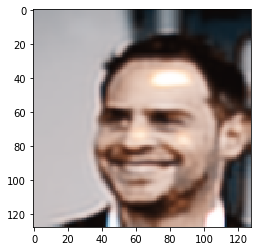

In [37]:
plt.imshow(y_predict[0][1])

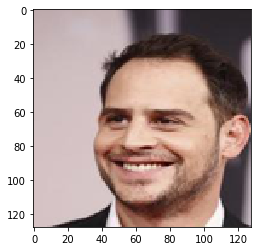

In [38]:
plt.imshow(x_train[1])